In [110]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import category_encoders as ce

from feature_engine.creation import CyclicalTransformer
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import PowerTransformer

from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from catboost import CatBoostRegressor
from catboost import Pool

from datetime import datetime

In [111]:
DATA_PATH = 'data/data_after_EDA.csv'
START_DATE = '01/25/2019'
END_DATE = '04/24/2022'

# Display all of the columns when data are shown
pd.set_option('display.max_columns', 60)

plt.rcParams['figure.figsize'] = (16, 8)

In [112]:
data =  pd.read_csv(DATA_PATH, sep=',', parse_dates=['doc_date', 'product_since'], low_memory=False)

In [113]:
data.head()

,bill_country,setting_currency_id,shop_basket_id,doc_date,exchange_currency_rate,original_currency_code,basket_total_price_with_vat,count_basket_items,basket_count_products,basket_type,item_quantity,item_type,item_unit_price_with_vat,item_total_discount_with_vat,product_id,product_code,catalog_category_id,catalog_brand_id,product_name,product_status,reviews_count,reviews_average_score_price,reviews_average_score_quality,reviews_average_score_properties,reviews_average_score_overall,reviews_average_score,is_in_stock,is_ended,is_new,is_boosted,product_purchase_price,eshop_stock_count,is_fifo,product_name_parameterize,product_since,category,tree_path,category_name_parameterized,category_status,catalog_segment_id,categories_ancestor_ids,categories_descendant_ids,category_full_name_path,default_warranty_period,brand_name,brand_parameterized,segment_name,segment_parameterized
0,BG,1,1136409,2020-04-26,1.9558,BGN,345.0,18,18,standard,1,standard,5.34,0.28,39848,225542,179.0,145,MC-2,active,83,95.192308,93.653846,93.653846,94.423077,94.277108,True,False,False,False,2.205000,-2.0,False,mc-2,2019-01-22,Kapodastre pre gitaru s kovovými strunami,001:001:019:001,kapodastre-pre-gitaru-s-kovovymi-strunami,active,1.0,"{3,4,178}",{},"{Music,Guitars,Capos,""Capo for acoustic guitar""}",24.0,Musedo,musedo,Music,music
1,BG,1,1136409,2020-04-26,1.9558,BGN,345.0,18,18,standard,1,standard,2.91,0.15,140119,305503,762.0,109,TGC026 1m,active,1,0.000000,0.000000,0.000000,0.000000,100.000000,False,False,False,False,1.385000,0.0,False,tgc026-1m,2019-02-21,Hotové nástrojové káble,001:005:010:001:001,hotove-nastrojove-kable,active,1.0,"{3,607,760,761}",{},"{Music,""Studio / PA"",Cables,""Complete Cables"",...",24.0,Lewitz,lewitz,Music,music
2,BG,1,1136409,2020-04-26,1.9558,BGN,345.0,18,18,standard,1,standard,0.49,0.03,34663,220357,153.0,13,351 Shape Premium Pick Medium White Moto,active,46,92.258065,93.225806,94.516129,94.193548,94.804348,True,False,False,False,0.164983,301.0,False,351-shape-premium-pick-medium-white-moto,2019-01-22,Medium trsátka,001:001:015:002,medium-trsatka,active,1.0,"{3,4,151}",{},"{Music,Guitars,""Guitar Picks"",""Medium Picks""}",24.0,Fender,fender,Music,music
3,BG,1,1136409,2020-04-26,1.9558,BGN,345.0,18,18,standard,1,standard,4.86,0.26,63176,248871,192.0,320,536501 Foot Rest Blue,active,10,92.500000,87.500000,92.500000,90.000000,92.500000,True,False,False,False,3.243455,55.0,False,536501-foot-rest-blue,2019-01-22,Gitarové podnožky,001:001:024,gitarove-podnozky,active,1.0,"{3,4}",{},"{Music,Guitars,""Guitar Foot Rest""}",24.0,GEWA,gewa,Music,music
4,BG,1,1136409,2020-04-26,1.9558,BGN,345.0,18,18,standard,1,standard,0.49,0.03,51524,237219,152.0,6,BPK-72-AT Celluloid Pick Thin Abalone,active,0,0.000000,0.000000,0.000000,0.000000,0.000000,True,True,False,False,0.138880,0.0,False,bpk-72-at-celluloid-pick-thin-abalone,2019-01-22,Light trsátka,001:001:015:001,light-trsatka,active,1.0,"{3,4,151}",{},"{Music,Guitars,""Guitar Picks"",""Light Picks""}",24.0,Boss,boss,Music,music


In [114]:
print(data.isna().sum())

bill_country                        0
setting_currency_id                 0
shop_basket_id                      0
doc_date                            0
exchange_currency_rate              0
original_currency_code              0
basket_total_price_with_vat         0
count_basket_items                  0
basket_count_products               0
basket_type                         0
item_quantity                       0
item_type                           0
item_unit_price_with_vat            0
item_total_discount_with_vat        0
product_id                          0
product_code                        0
catalog_category_id                 0
catalog_brand_id                    0
product_name                        0
product_status                      0
reviews_count                       0
reviews_average_score_price         0
reviews_average_score_quality       0
reviews_average_score_properties    0
reviews_average_score_overall       0
reviews_average_score               0
is_in_stock 

# 1. Change non-numeric values to numbers

Machine learning models usually work only with numeric values (integers or floats) - that's why we need to change other formats to numbers. 

In [115]:
type(data.product_since[0])

pandas._libs.tslibs.timestamps.Timestamp

In [116]:
data.dtypes

bill_country                                object
setting_currency_id                          int64
shop_basket_id                               int64
doc_date                            datetime64[ns]
exchange_currency_rate                     float64
original_currency_code                      object
basket_total_price_with_vat                float64
count_basket_items                           int64
basket_count_products                        int64
basket_type                                 object
item_quantity                                int64
item_type                                   object
item_unit_price_with_vat                   float64
item_total_discount_with_vat               float64
product_id                                   int64
product_code                                 int64
catalog_category_id                        float64
catalog_brand_id                             int64
product_name                                object
product_status                 

At first let's start with breaking down dates to four different columns - we can extract day of the month, day of the week, week, month and year. We will still keep the original datetime column in code, because it can be useful to easier access date (rather then creating it from columns). \
We will also add an information about how long the item is available in eshop.

In [117]:
years, months, days, weeks, weekdays = [], [], [], [], []
for date in data.doc_date:
    years.append(date.year)
    months.append(date.month)
    days.append(date.day)
    weekdays.append(date.weekday())
    weeks.append(date.week)
    
    

data['doc_day'] = days
data['doc_month'] = months
data['doc_year'] = years
data['doc_weekday'] = weekdays
data['doc_week'] = weeks

In [118]:
days_in_shop = []
for prod_date in data.product_since:
    days_in_shop.append((datetime.strptime(END_DATE, '%m/%d/%Y') - prod_date).days)
    
data['days_in_shop'] = days_in_shop

**The next part is to find columns that already have their natural number representation - i.e. product_name_parameterize is not necesarry column as we have product_id (numeric products identification)**

In [119]:
# rename catalog_COLUMN to COLUMN only so it is easier to understand
data.rename(columns={'catalog_category_id' : 'category_id', 'catalog_segment_id' : 'segment_id', 'catalog_brand_id' : 'brand_id'}, inplace=True)

# rename other id columns with extra words to pure defining id in similar spirit as with catalog
data.rename(columns={'setting_currency_id' : 'currency_id', 'shop_basket_id' : 'basket_id'}, inplace=True)

In [120]:
def leave_only_id_column(df : pd.DataFrame(), id_column : str, other_columns : list, inplace : bool = False) -> pd.DataFrame():
    """
    Function that counts and compares if product_id is proper representation of other given columns. If yes, then drop other columns and leave id only.
    Args
        df - pandas DataFrame containing desired columns
        id_column - main column containing identificator, this column will be the only one remaining
        other_columns - list of other columns, those will be compared and possibly dropped
        inplace - If False, return a copy. Otherwise, do operation inplace and return None.
    Returns
        pd.DataFrame - DataFrame with removed columns in other_columns or None if inplace is True
    """
    id_col_len = len(data[id_column].unique())
    
    unique_combinations = len(df[other_columns + [id_column]].drop_duplicates().index)
    other_cols_string = ''
    for name in other_columns:
        other_cols_string += name+', '
    
    print(f"{id_col_len} - Unique {id_column} amount.")
    print(f"{unique_combinations} - Amount of unique combinations of {id_column} and {other_cols_string}")
    
    missmatches_amount = abs(id_col_len - unique_combinations)
    print(f"{missmatches_amount} - How many missmatches between {id_column} and other columns.")
    
    if missmatches_amount == 0:
        if inplace:
            df.drop(labels=other_columns, inplace=inplace, axis=1)
            return None
        else:
            return df.drop(labels=other_columns, inplace=inplace, axis=1)
        
    else: 
        print('There were missmatches, not dropping any columns.')
        return None

Because each product id represents one product correctly, we can drop product name as well as parameterized product name. \
We can drop product_code as well for the same reason - product id represents same products as product_code but in different encodings.

In [121]:
leave_only_id_column(data, 'product_id', ['product_name', 'product_code'], inplace=True)
print('\n')

leave_only_id_column(data, 'product_id', ['product_name_parameterize'], inplace=True)

164386 - Unique product_id amount.
164386 - Amount of unique combinations of product_id and product_name, product_code, 
0 - How many missmatches between product_id and other columns.


164386 - Unique product_id amount.
164386 - Amount of unique combinations of product_id and product_name_parameterize, 
0 - How many missmatches between product_id and other columns.


Similar to products, there is many alike records in data (columns represented by other column), we can take care of all of them. 

In [122]:
leave_only_id_column(data, 'category_id', ['category', 'category_name_parameterized'], inplace=True)

2465 - Unique category_id amount.
2465 - Amount of unique combinations of category_id and category, category_name_parameterized, 
0 - How many missmatches between category_id and other columns.


In [123]:
leave_only_id_column(data, 'brand_id', ['brand_name', 'brand_parameterized'], inplace=True)

5326 - Unique brand_id amount.
5326 - Amount of unique combinations of brand_id and brand_name, brand_parameterized, 
0 - How many missmatches between brand_id and other columns.


In [124]:
leave_only_id_column(data, 'currency_id', ['original_currency_code'], inplace=True)

10 - Unique currency_id amount.
10 - Amount of unique combinations of currency_id and original_currency_code, 
0 - How many missmatches between currency_id and other columns.


In [125]:
leave_only_id_column(data, 'segment_id', ['segment_parameterized', 'segment_name'], inplace=True)

15 - Unique segment_id amount.
15 - Amount of unique combinations of segment_id and segment_parameterized, segment_name, 
0 - How many missmatches between segment_id and other columns.


In [126]:
leave_only_id_column(data, 'tree_path', ['category_full_name_path'], inplace=True)

2465 - Unique tree_path amount.
2465 - Amount of unique combinations of tree_path and category_full_name_path, 
0 - How many missmatches between tree_path and other columns.


In [127]:
# In tree path we want to keep it separated in two columns for now - categorty_descendants (parents) and category_ancestors (subcategories). We will check for missmatches and drop tree_path if there are none
leave_only_id_column(data, 'tree_path', ['categories_descendant_ids', 'categories_ancestor_ids'])

data.drop(labels='tree_path', axis=1, inplace=True)

2465 - Unique tree_path amount.
2465 - Amount of unique combinations of tree_path and categories_descendant_ids, categories_ancestor_ids, 
0 - How many missmatches between tree_path and other columns.


**Coding remaining string and boolean values to numerics** \
With the usage of replace (booleans) and OrdinalEncounter (strings) we will change values to their representation in numbers.

In [128]:
data.replace([True, False], [1, 0], inplace=True)

In [129]:
columns_to_change = ['bill_country',
 'basket_type',
 'item_type',
 'product_status',
 'category_status']

ce_ordinal = ce.OrdinalEncoder(cols=columns_to_change)
data = ce_ordinal.fit_transform(data)

for mapped in ce_ordinal.fit(data).mapping:
    print(f"Column {mapped['col']} has mapping of:")
    print(f"{mapped['mapping']} \n\n")

Column bill_country has mapping of:
BG      1
CZ      2
SK      3
PL      4
DE      5
SI      6
RO      7
FR      8
AT      9
HU     10
HR     11
IT     12
NL     13
DK     14
SE     15
BE     16
LT     17
GB     18
LV     19
IE     20
CH     21
PT     22
ES     23
LU     24
FI     25
EE     26
GR     27
EL     28
TR     29
UA     30
RS     31
BA     32
NaN    -2
dtype: int64 


Column basket_type has mapping of:
standard            1
internal            2
express_checkout    3
NaN                -2
dtype: int64 


Column item_type has mapping of:
standard           1
set                2
digital_licence    3
NaN               -2
dtype: int64 


Column product_status has mapping of:
active      1
archived    2
ended       3
inactive    4
NaN        -2
dtype: int64 


Column category_status has mapping of:
active      1
inactive    2
NaN        -2
dtype: int64 




Instead of saving full path to category we just want to know how deep given category is and how many subcategories it has. We will convert arrays of ancestors/ descendants into numbers representing amounts of ids in given lists.

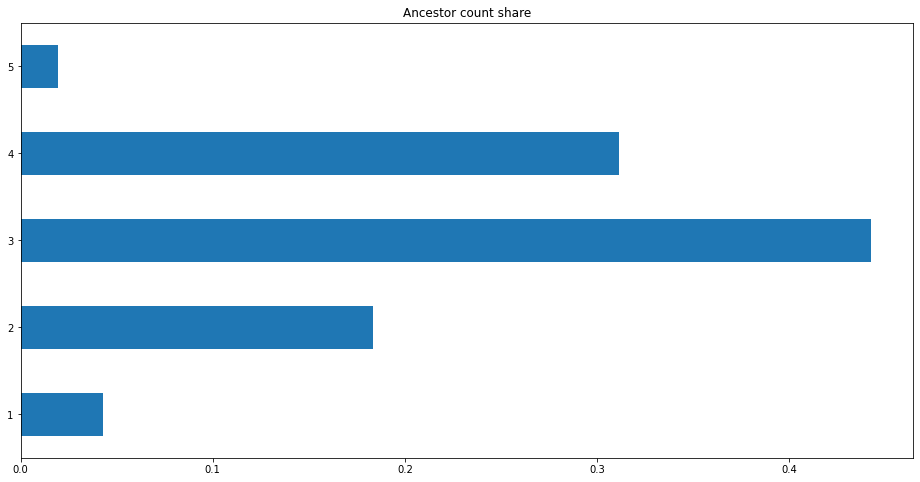

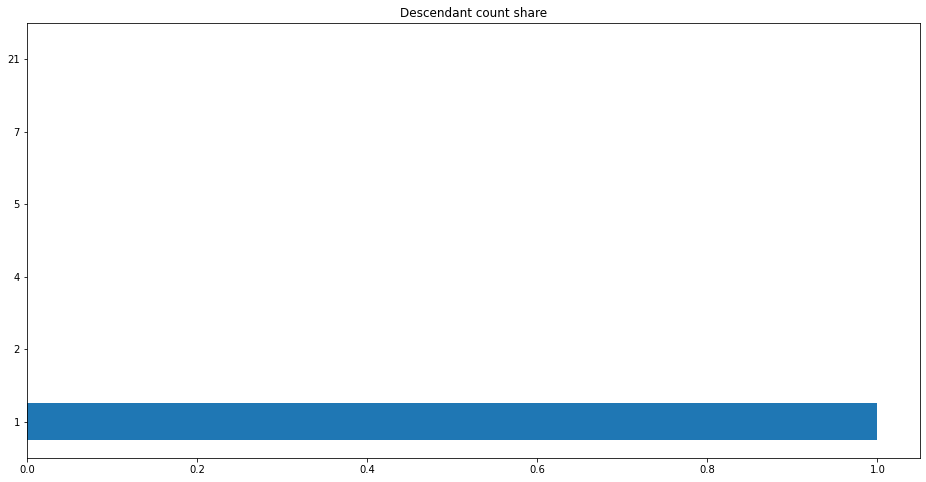

In [130]:
ancestor_count = [len(i.split(',')) for i in data.categories_ancestor_ids]
descendant_count = [len(i.split(',')) for i in data.categories_descendant_ids]

data['ancestor_count'] = ancestor_count
data['descendant_count'] = descendant_count

data.ancestor_count.value_counts(normalize=True).sort_index().plot(kind='barh', title='Ancestor count share')
plt.show()

data.descendant_count.value_counts(normalize=True).sort_index().plot(kind='barh', title='Descendant count share')
plt.show()

data.drop(labels=['categories_ancestor_ids', 'categories_descendant_ids'], axis=1, inplace=True)

In [132]:
data.columns

Index(['bill_country', 'currency_id', 'basket_id', 'doc_date',
       'exchange_currency_rate', 'basket_total_price_with_vat',
       'count_basket_items', 'basket_count_products', 'basket_type',
       'item_quantity', 'item_type', 'item_unit_price_with_vat',
       'item_total_discount_with_vat', 'product_id', 'category_id', 'brand_id',
       'product_status', 'reviews_count', 'reviews_average_score_price',
       'reviews_average_score_quality', 'reviews_average_score_properties',
       'reviews_average_score_overall', 'reviews_average_score', 'is_in_stock',
       'is_ended', 'is_new', 'is_boosted', 'product_purchase_price',
       'eshop_stock_count', 'is_fifo', 'product_since', 'category_status',
       'segment_id', 'default_warranty_period', 'doc_day', 'doc_month',
       'doc_year', 'doc_weekday', 'doc_week', 'days_in_shop', 'ancestor_count',
       'descendant_count'],
      dtype='object')

# 2. Dealing with outliers

In this part we want to delete outliers, as those might negatively influenece machine learning algorithm. That is why we want to delete at least the first iteration of outliers. There is ~5% values as outliers in the first iteration, which, we consider, is reasonable price to pay for cleaner and more useful data.\
We are considering values further than *3x standard deviations ($\sigma$) from the mean ($\mu$)* as outliers in our preprocessing.

In [133]:
 def delete_outliers(df : pd.DataFrame) -> pd.DataFrame:
    """
    Function deletes rows containing outlier value in any of the columns and returns adjusted dataframe
    Args
        df - dataframe containing columns to check for outliers
    Returns
        DataFrame without outlier values
    """
    for cols in df.columns:    
        # Check for each column in the dataframe    
        data_frame = df[cols]
        data_mean, data_std = np.mean(data_frame), np.std(data_frame)  # Outlier > mean+3*std OR outlier < mean-3*std

        # Outliers percentage definition
        cut_off = data_std * 3
        lower, upper = data_mean - cut_off, data_mean + cut_off 

        # Identify and remove outliers
        outliers = [False if x < lower or x > upper else True for x in data_frame] 
            
        # Information for the user about deleting rows based on given column
        if outliers.count(False) > 0:
            print(f'Identified outliers: {outliers.count(False)} in column: {cols}')
        df = df[outliers]

    return df

In [134]:
check_outliers_columns = ['basket_total_price_with_vat', 
                          'count_basket_items', 
                          'basket_count_products', 
                          'item_quantity', 
                          'item_unit_price_with_vat', 
                          'item_total_discount_with_vat', 
                          'reviews_count', 
                          'reviews_average_score_price', 
                          'reviews_average_score_quality', 
                          'reviews_average_score_properties', 
                          'reviews_average_score_overall',
                          'reviews_average_score', 
                          'product_purchase_price',
                          'eshop_stock_count', 
                          'ancestor_count', 
                          'descendant_count']

In [136]:
for col in check_outliers_columns:
    data[col] = delete_outliers(data[[col]])
    data.dropna(inplace=True)

Identified outliers: 6 in column: basket_total_price_with_vat
Identified outliers: 16525 in column: count_basket_items
Identified outliers: 38830 in column: basket_count_products
Identified outliers: 42171 in column: item_quantity
Identified outliers: 50815 in column: item_unit_price_with_vat
Identified outliers: 37948 in column: item_total_discount_with_vat
Identified outliers: 17914 in column: reviews_count
Identified outliers: 70247 in column: product_purchase_price
Identified outliers: 14862 in column: eshop_stock_count
Identified outliers: 607 in column: descendant_count


# 3. Normalization

In [27]:
#min_max_columns = ['']

scaler = MinMaxScaler()
scaled = scaler.fit_transform(data[scaled_columns])
scaled = pd.DataFrame(scaled, columns = scaled_columns)

NameError: name 'scaled_columns' is not defined

In [28]:
data

,bill_country,currency_id,basket_id,doc_date,exchange_currency_rate,basket_total_price_with_vat,count_basket_items,basket_count_products,basket_type,item_quantity,item_type,item_unit_price_with_vat,item_total_discount_with_vat,product_id,category_id,brand_id,product_status,reviews_count,reviews_average_score_price,reviews_average_score_quality,reviews_average_score_properties,reviews_average_score_overall,reviews_average_score,is_in_stock,is_ended,is_new,is_boosted,product_purchase_price,eshop_stock_count,is_fifo,product_since,category_status,segment_id,default_warranty_period,doc_day,doc_month,doc_year,doc_weekday,doc_week,days_in_shop,ancestor_count,descendant_count
0,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,5.34,0.28,39848,179.0,145,1,83.0,95.192308,93.653846,93.653846,94.423077,94.277108,1,0,0,0,2.205000,-2.0,0,2019-01-22,1,1.0,24.0,26,4,2020,6,17,1188,3,1.0
1,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,2.91,0.15,140119,762.0,109,1,1.0,0.000000,0.000000,0.000000,0.000000,100.000000,0,0,0,0,1.385000,0.0,0,2019-02-21,1,1.0,24.0,26,4,2020,6,17,1158,4,1.0
2,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,0.49,0.03,34663,153.0,13,1,46.0,92.258065,93.225806,94.516129,94.193548,94.804348,1,0,0,0,0.164983,301.0,0,2019-01-22,1,1.0,24.0,26,4,2020,6,17,1188,3,1.0
3,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,4.86,0.26,63176,192.0,320,1,10.0,92.500000,87.500000,92.500000,90.000000,92.500000,1,0,0,0,3.243455,55.0,0,2019-01-22,1,1.0,24.0,26,4,2020,6,17,1188,2,1.0
4,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,0.49,0.03,51524,152.0,6,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,0,0,0.138880,0.0,0,2019-01-22,1,1.0,24.0,26,4,2020,6,17,1188,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3003430,5,6,1737232,2020-09-19,1.0000,129.90,1.0,1.0,1,1.0,1,129.90,0.00,4632,6.0,54,1,16.0,97.500000,91.250000,91.250000,31.250000,77.812500,1,0,0,0,69.383125,16.0,0,2019-01-22,1,1.0,24.0,19,9,2020,5,38,1188,3,1.0
3003431,2,4,63279,2019-03-01,26.4680,135.64,1.0,1.0,1,1.0,1,135.64,0.00,26939,92.0,11,3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,90.400000,0.0,0,2019-01-22,1,1.0,24.0,1,3,2019,4,9,1188,4,1.0
3003432,16,6,1737241,2020-09-19,1.0000,292.70,17.0,17.0,1,1.0,1,21.30,0.00,216256,2042.0,1900,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,0,12.953333,6.0,0,2020-07-15,1,16.0,24.0,19,9,2020,5,38,648,1,1.0
3003433,16,6,1737241,2020-09-19,1.0000,292.70,17.0,17.0,1,1.0,1,16.90,0.90,192200,2042.0,3496,3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,11.900000,0.0,0,2019-12-06,1,16.0,24.0,19,9,2020,5,38,870,1,1.0


In [29]:
TODO_TRANSFORM = list(data.columns)
TODO_TRANSFORM.remove('doc_day')
TODO_TRANSFORM.remove('doc_week')
TODO_TRANSFORM.remove('doc_year')
TODO_TRANSFORM.remove('doc_weekday')
TODO_TRANSFORM.remove('doc_month')
TODO_TRANSFORM.remove('doc_date')
TODO_TRANSFORM.remove('is_in_stock')
TODO_TRANSFORM.remove('is_ended')
TODO_TRANSFORM.remove('is_new')
TODO_TRANSFORM.remove('is_fifo')
TODO_TRANSFORM

['bill_country',
 'currency_id',
 'basket_id',
 'exchange_currency_rate',
 'basket_total_price_with_vat',
 'count_basket_items',
 'basket_count_products',
 'basket_type',
 'item_quantity',
 'item_type',
 'item_unit_price_with_vat',
 'item_total_discount_with_vat',
 'product_id',
 'category_id',
 'brand_id',
 'product_status',
 'reviews_count',
 'reviews_average_score_price',
 'reviews_average_score_quality',
 'reviews_average_score_properties',
 'reviews_average_score_overall',
 'reviews_average_score',
 'is_boosted',
 'product_purchase_price',
 'eshop_stock_count',
 'product_since',
 'category_status',
 'segment_id',
 'default_warranty_period',
 'days_in_shop',
 'ancestor_count',
 'descendant_count']

In [30]:
cyclical = CyclicalTransformer(variables=['doc_day', 'doc_week', 'doc_weekday', 'doc_month'], drop_original=True)
cyclical.fit_transform(data)

,bill_country,currency_id,basket_id,doc_date,exchange_currency_rate,basket_total_price_with_vat,count_basket_items,basket_count_products,basket_type,item_quantity,item_type,item_unit_price_with_vat,item_total_discount_with_vat,product_id,category_id,brand_id,product_status,reviews_count,reviews_average_score_price,reviews_average_score_quality,reviews_average_score_properties,reviews_average_score_overall,reviews_average_score,is_in_stock,is_ended,is_new,is_boosted,product_purchase_price,eshop_stock_count,is_fifo,product_since,category_status,segment_id,default_warranty_period,doc_year,days_in_shop,ancestor_count,descendant_count,doc_day_sin,doc_day_cos,doc_week_sin,doc_week_cos,doc_weekday_sin,doc_weekday_cos,doc_month_sin,doc_month_cos
0,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,5.34,0.28,39848,179.0,145,1,83.0,95.192308,93.653846,93.653846,94.423077,94.277108,1,0,0,0,2.205000,-2.0,0,2019-01-22,1,1.0,24.0,2020,1188,3,1.0,-0.848644,0.528964,0.902798,-0.430065,-2.449294e-16,1.0,0.866025,-5.000000e-01
1,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,2.91,0.15,140119,762.0,109,1,1.0,0.000000,0.000000,0.000000,0.000000,100.000000,0,0,0,0,1.385000,0.0,0,2019-02-21,1,1.0,24.0,2020,1158,4,1.0,-0.848644,0.528964,0.902798,-0.430065,-2.449294e-16,1.0,0.866025,-5.000000e-01
2,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,0.49,0.03,34663,153.0,13,1,46.0,92.258065,93.225806,94.516129,94.193548,94.804348,1,0,0,0,0.164983,301.0,0,2019-01-22,1,1.0,24.0,2020,1188,3,1.0,-0.848644,0.528964,0.902798,-0.430065,-2.449294e-16,1.0,0.866025,-5.000000e-01
3,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,4.86,0.26,63176,192.0,320,1,10.0,92.500000,87.500000,92.500000,90.000000,92.500000,1,0,0,0,3.243455,55.0,0,2019-01-22,1,1.0,24.0,2020,1188,2,1.0,-0.848644,0.528964,0.902798,-0.430065,-2.449294e-16,1.0,0.866025,-5.000000e-01
4,1,1,1136409,2020-04-26,1.9558,345.00,18.0,18.0,1,1.0,1,0.49,0.03,51524,152.0,6,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,0,0,0.138880,0.0,0,2019-01-22,1,1.0,24.0,2020,1188,3,1.0,-0.848644,0.528964,0.902798,-0.430065,-2.449294e-16,1.0,0.866025,-5.000000e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3003430,5,6,1737232,2020-09-19,1.0000,129.90,1.0,1.0,1,1.0,1,129.90,0.00,4632,6.0,54,1,16.0,97.500000,91.250000,91.250000,31.250000,77.812500,1,0,0,0,69.383125,16.0,0,2019-01-22,1,1.0,24.0,2020,1188,3,1.0,-0.651372,-0.758758,-0.978556,-0.205979,-8.660254e-01,0.5,-1.000000,-1.836970e-16
3003431,2,4,63279,2019-03-01,26.4680,135.64,1.0,1.0,1,1.0,1,135.64,0.00,26939,92.0,11,3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,90.400000,0.0,0,2019-01-22,1,1.0,24.0,2019,1188,4,1.0,0.201299,0.979530,0.875735,0.482792,-8.660254e-01,-0.5,1.000000,6.123234e-17
3003432,16,6,1737241,2020-09-19,1.0000,292.70,17.0,17.0,1,1.0,1,21.30,0.00,216256,2042.0,1900,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1,0,0,0,12.953333,6.0,0,2020-07-15,1,16.0,24.0,2020,648,1,1.0,-0.651372,-0.758758,-0.978556,-0.205979,-8.660254e-01,0.5,-1.000000,-1.836970e-16
3003433,16,6,1737241,2020-09-19,1.0000,292.70,17.0,17.0,1,1.0,1,16.90,0.90,192200,2042.0,3496,3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,11.900000,0.0,0,2019-12-06,1,16.0,24.0,2020,870,1,1.0,-0.651372,-0.758758,-0.978556,-0.205979,-8.660254e-01,0.5,-1.000000,-1.836970e-16


# 4. Clustering

In [137]:
kmeansable = data[[
 'item_type',
 'product_id',
 'category_id',
 'brand_id',
 'product_status',
 'reviews_count',
 'reviews_average_score_price',
 'reviews_average_score_quality',
 'reviews_average_score_properties',
 'reviews_average_score_overall',
 'reviews_average_score',
 'is_in_stock',
 'is_ended',
 'is_new',
 'product_purchase_price',
 'eshop_stock_count',
 'is_fifo',
 'category_status',
 'segment_id',
 'default_warranty_period',
 'ancestor_count',
 'descendant_count',
 'days_in_shop'   
]].drop_duplicates()

At first we will use kMeans clustering, as agglomerative clustering can be done on large dataset easier than other types.

In [138]:
# Declaring Model
model = KMeans(n_clusters=101)

# Fitting Model
model.fit(kmeansable)

# Prediction on the entire data
all_predictions = model.predict(kmeansable)

kmeansable['kmeans_cluster'] = all_predictions

<BarContainer object of 101 artists>

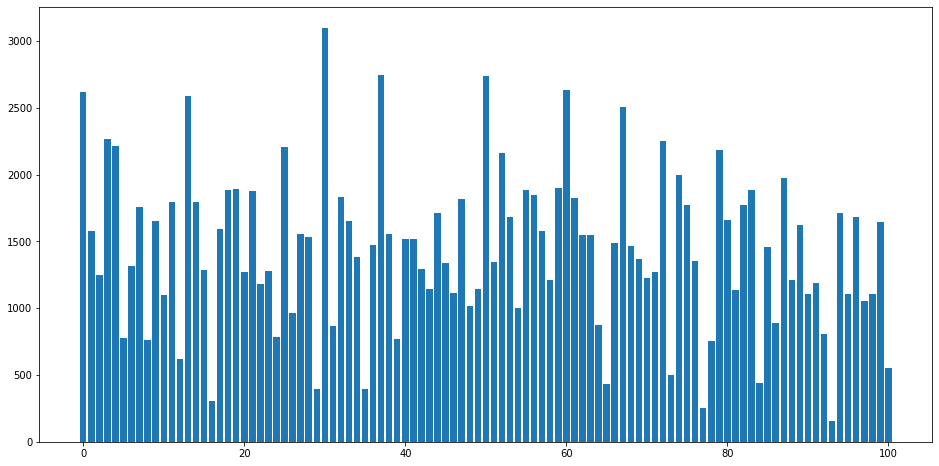

In [139]:
unique, counts = np.unique(all_predictions, return_counts = True)
plt.bar(unique, counts)

In [140]:
cluster_tester = kmeansable[kmeansable.kmeans_cluster.__eq__(2)]

<ipython-input-141-0f77b9dd41c4>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_tester['cluster_hierar'] = tmp


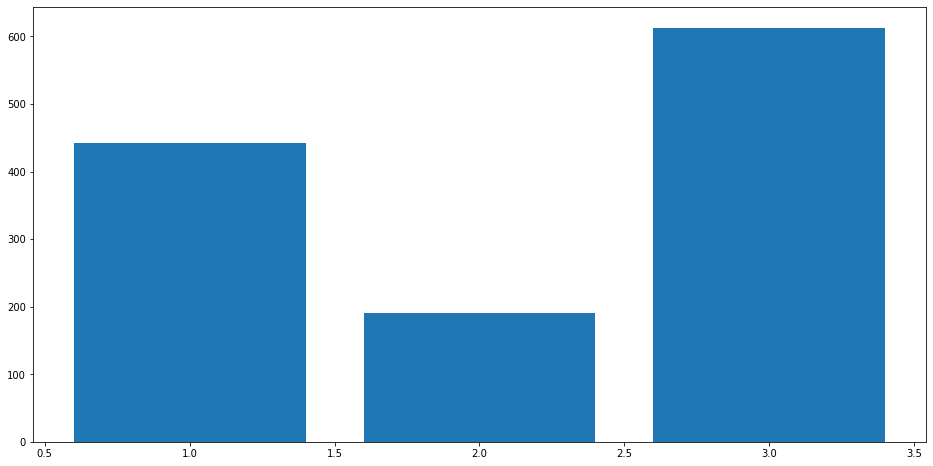

In [141]:
# Import the fcluster and linkage functions
from scipy.cluster.hierarchy import fcluster, linkage
 
# Use the linkage() function
distance_matrix = linkage(cluster_tester, method = 'ward', metric = 'euclidean')
                                      
tmp = fcluster(distance_matrix, 3, criterion='maxclust')

unique, counts = np.unique(tmp, return_counts = True)
plt.bar(unique, counts)
plt.plot()
cluster_tester['cluster_hierar'] = tmp

In [142]:
cluster_tester = cluster_tester[cluster_tester.cluster_hierar.__eq__(1)]

In [151]:
test_predict = data[data.product_id.isin(cluster_tester.product_id.values)]

# 5. Prediction

#### Drop unsettable columns
We want to predict, how many items of given type we will sell. That means - the predicted column will be 'item_quantity'. We don't know, how many items will be in basket, it's type etc. We only know values of columns we can influence (or which are already written) - for example price of the product, or it's brand. These columns were great for clustering products, as they can show some patterns in them, but for pure pretictions we are dropping those data.

In [147]:
test_predict

,doc_date,item_quantity,item_type,item_unit_price_with_vat,item_total_discount_with_vat,product_id,category_id,brand_id,product_status,reviews_count,reviews_average_score_price,reviews_average_score_quality,reviews_average_score_properties,reviews_average_score_overall,reviews_average_score,is_in_stock,is_ended,is_new,is_boosted,product_purchase_price,eshop_stock_count,is_fifo,product_since,category_status,segment_id,default_warranty_period,doc_day,doc_month,doc_year,doc_weekday,doc_week,days_in_shop,ancestor_count,descendant_count
99,2020-05-11,1.0,1,39.88,0.00,31961,76.0,85,1,23.0,95.500000,87.500000,94.000000,94.500000,93.913043,1,0,0,0,25.210000,5.0,0,2019-01-22,1,1.0,24.0,11,5,2020,0,20,1188,3,1.0
154,2020-05-12,1.0,1,11.25,0.00,31728,192.0,187,1,32.0,96.000000,98.000000,97.500000,97.500000,98.312500,1,0,0,0,7.413684,19.0,0,2019-01-22,1,1.0,24.0,12,5,2020,1,20,1188,2,1.0
185,2020-05-12,1.0,1,88.97,0.00,32057,99.0,6,1,34.0,94.375000,99.062500,91.875000,96.562500,95.882353,1,0,0,0,77.797750,0.0,0,2019-01-22,1,1.0,24.0,12,5,2020,1,20,1188,4,1.0
267,2020-05-14,1.0,1,39.88,0.00,30856,609.0,1,1,79.0,82.580645,85.483871,81.612903,81.290323,90.443038,1,0,0,0,25.946667,-5.0,0,2019-01-22,1,1.0,24.0,14,5,2020,3,20,1188,3,1.0
309,2020-05-15,1.0,1,55.31,1.44,32056,108.0,6,1,4.0,90.000000,100.000000,100.000000,97.500000,96.875000,1,0,0,0,44.106667,6.0,0,2019-01-22,1,1.0,24.0,15,5,2020,4,20,1188,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3002928,2021-06-09,1.0,1,11.72,0.00,30669,861.0,13,1,63.0,91.090909,91.090909,86.363636,90.727273,90.920635,1,0,0,0,7.684839,31.0,0,2019-01-22,1,1.0,24.0,9,6,2021,2,23,1188,4,1.0
3002975,2020-07-27,1.0,1,11.50,0.26,30669,861.0,13,1,63.0,91.090909,91.090909,86.363636,90.727273,90.920635,1,0,0,0,7.684839,31.0,0,2019-01-22,1,1.0,24.0,27,7,2020,0,31,1188,4,1.0
3003192,2021-08-04,1.0,1,11.44,0.00,30669,861.0,13,1,63.0,91.090909,91.090909,86.363636,90.727273,90.920635,1,0,0,0,7.684839,31.0,0,2019-01-22,1,1.0,24.0,4,8,2021,2,31,1188,4,1.0
3003240,2019-02-20,1.0,1,11.30,0.00,32211,196.0,388,1,6.0,83.333333,86.666667,86.666667,76.666667,88.333333,1,0,0,0,4.147217,0.0,0,2019-01-22,1,1.0,24.0,20,2,2019,2,8,1188,3,1.0


In [152]:
#data.drop(labels=['basket_id', 'basket_total_price_with_vat', 'basket_count_products', 'basket_type', 'count_basket_items'], axis=1, inplace=True)
test_predict.drop(labels=['basket_id', 'basket_total_price_with_vat', 'basket_count_products', 'basket_type', 'count_basket_items', 'bill_country', 'currency_id', 'exchange_currency_rate', 'is_in_stock', 'eshop_stock_count'], axis=1, inplace=True)

<ipython-input-152-0adfca86325f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_predict.drop(labels=['basket_id', 'basket_total_price_with_vat', 'basket_count_products', 'basket_type', 'count_basket_items', 'bill_country', 'currency_id', 'exchange_currency_rate', 'is_in_stock', 'eshop_stock_count'], axis=1, inplace=True)


In [196]:
def fill_zeroes(df : pd.DataFrame) -> pd.DataFrame:
    """
    Add days when there were no products sold    
    """
    date_column = 'doc_date'

    try:
        dates = pd.date_range(start=df.product_since.iloc[0], end=END_DATE)
    except:
        # If there is no sale of given product
        return pd.DataFrame(columns=['product_id', 'invoice_date', 'quantity_sold'])

    sales = []
    for date in dates:
        # if there is existing number of sales for given day, otherwise we know there are no such occurances
        if len(df[df[date_column] == date]['item_quantity']) > 0:
            sales.append(df[df[date_column] == date]['item_quantity'].sum())
        else:
            sales.append(0)

    full_sales = pd.DataFrame()        
    full_sales['product_id'] = [df.product_id.iloc[0] for i in range(len(dates))]
    full_sales['sale_date'] = dates
    full_sales['quantity_sold'] = sales
    return full_sales

In [193]:
daily_sales = pd.DataFrame()
for prod in test_predict.product_id.unique():
    daily_sales = pd.concat([daily_sales, fill_zeroes(test_predict[test_predict.product_id.__eq__(prod)])])

In [198]:
daily_sales.sort_values(by='invoice_date', inplace=True)

In [201]:
years, months, days, weeks, weekdays = [], [], [], [], []
for date in daily_sales.invoice_date:
    years.append(date.year)
    months.append(date.month)
    days.append(date.day)
    weekdays.append(date.weekday())
    weeks.append(date.week)
    
    

daily_sales['sale_day'] = days
daily_sales['sale_month'] = months
daily_sales['sale_year'] = years
daily_sales['sale_weekday'] = weekdays
daily_sales['sale_week'] = weeks

In [207]:
train = daily_sales[daily_sales.invoice_date <= '12/31/2021']
test = daily_sales[daily_sales.invoice_date > '12/31/2021']

In [208]:
model = CatBoostRegressor(
    iterations=1000, 
    learning_rate=0.02, 
    max_depth=10, 
    l2_leaf_reg=10, 
    loss_function='RMSE',
    random_seed=1,
    od_type='Iter',
    od_wait=25,
    verbose=100,
    use_best_model=False
    )

In [209]:
daily_sales

,product_id,invoice_date,quantity_sold,sale_day,sale_month,sale_year,sale_weekday,sale_week
0,31961,2019-01-22,0.0,22,1,2019,1,4
0,31992,2019-01-22,0.0,22,1,2019,1,4
0,32218,2019-01-22,0.0,22,1,2019,1,4
0,32222,2019-01-22,0.0,22,1,2019,1,4
0,32037,2019-01-22,0.0,22,1,2019,1,4
...,...,...,...,...,...,...,...,...
1188,31700,2022-04-24,0.0,24,4,2022,6,16
1188,30914,2022-04-24,0.0,24,4,2022,6,16
1188,31843,2022-04-24,0.0,24,4,2022,6,16
1188,32197,2022-04-24,0.0,24,4,2022,6,16


In [ ]:
model = CatBoostRegressor(
    iterations=1000, 
    learning_rate=0.02, 
    max_depth=10, 
    l2_leaf_reg=10, 
    loss_function='RMSE',
    random_seed=1,
    od_type='Iter',
    od_wait=25,
    verbose=100,
    use_best_model=False
    )

In [210]:
model.fit(train.drop(labels=['invoice_date', 'quantity_sold'], axis=1), train.quantity_sold,
              early_stopping_rounds=3000,
              verbose=100)

0:	learn: 0.5057609	total: 131ms	remaining: 2m 11s
100:	learn: 0.4767369	total: 4.01s	remaining: 35.7s
200:	learn: 0.4717458	total: 7.94s	remaining: 31.6s
300:	learn: 0.4689122	total: 11.9s	remaining: 27.6s
400:	learn: 0.4669381	total: 15.9s	remaining: 23.7s
500:	learn: 0.4652721	total: 19.9s	remaining: 19.8s
600:	learn: 0.4640688	total: 23.9s	remaining: 15.9s
700:	learn: 0.4627785	total: 28s	remaining: 11.9s
800:	learn: 0.4616999	total: 32s	remaining: 7.95s
900:	learn: 0.4606844	total: 36.2s	remaining: 3.98s
999:	learn: 0.4597191	total: 40.5s	remaining: 0us


In [222]:
predicted = [model.predict(train.drop(labels=['invoice_date', 'quantity_sold'], axis=1).iloc[i]) for i in range (len(train.index))]

SyntaxError: invalid syntax (<ipython-input-222-2eaefca36060>, line 1)

In [227]:
X = train.drop(labels=['invoice_date', 'quantity_sold'], axis=1)

In [229]:
predicted = []
for i in range (len(train.index)):
    predicted.append(model.predict(X.iloc[i]))
    if i % 1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


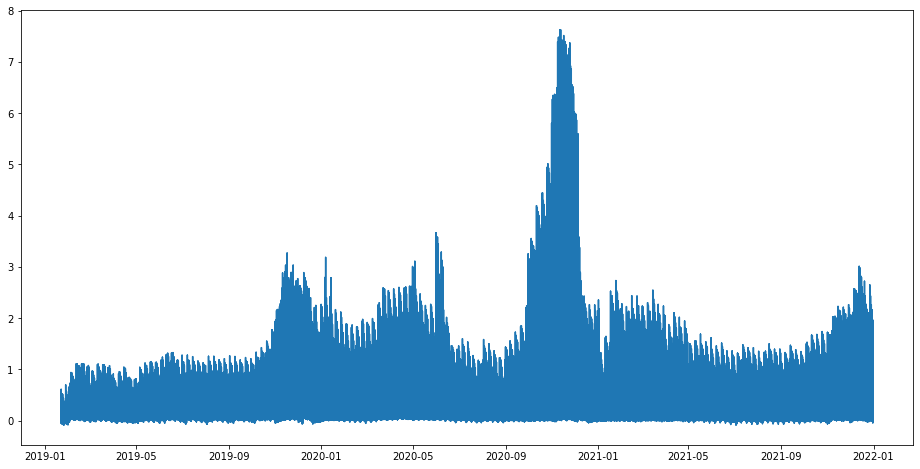

In [234]:
plt.plot(train.invoice_date, predicted)
plt.show()

In [224]:
print(i)

455799


In [235]:
original = list(train.quantity_sold.values)

In [246]:
new = train[['invoice_date', 'quantity_sold']]

In [250]:
new = new.groupby('invoice_date').sum()

In [253]:
tmp = pd.DataFrame()
tmp['date'] = train.invoice_date
tmp['predicted'] = predicted
tmp = tmp.groupby('date').sum()
tmp

,predicted
date,
2019-01-22,9.476990
2019-01-23,5.436473
2019-01-24,3.998373
2019-01-25,-0.507195
2019-01-26,-0.639249
...,...
2021-12-27,42.975207
2021-12-28,31.560792
2021-12-29,25.761412


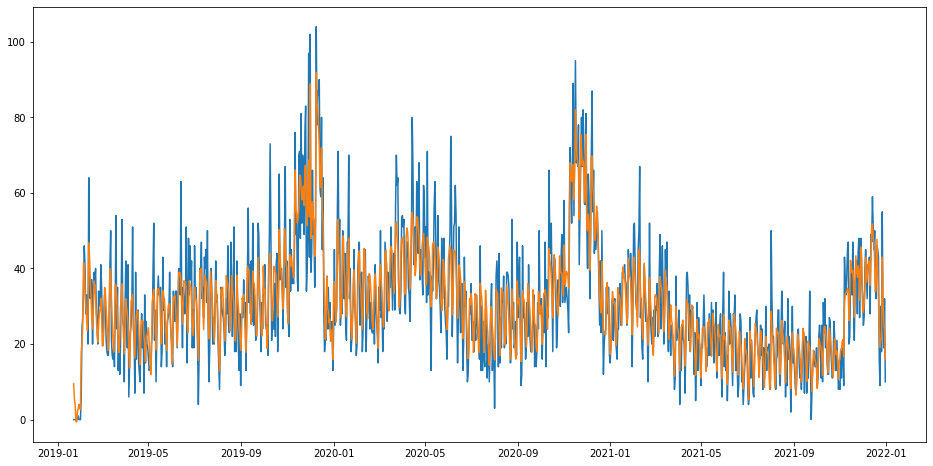

In [254]:
plt.plot(new)
plt.plot(tmp)
plt.show()

In [59]:
train_predict = test_predict[9500:]
test_predict = test_predict[:9500]

# separated_values.columns[1:] means all but the first column == quantity_sold
model.fit(test_predict.drop(labels=['doc_date', 'item_quantity', 'product_since'], axis=1), test_predict['item_quantity'],
              early_stopping_rounds=3000,
              verbose=100)

In [62]:
predicted = [model.predict(test_predict.drop(labels=['doc_date', 'item_quantity', 'product_since'], axis=1).iloc[i]) for i in range (len(test_predict.index))]

In [63]:
orig = list(test_predict.item_quantity.values)

In [64]:
sum(orig)

826.0

In [65]:
sum(predicted)

822.2419465679412

In [66]:
pred_test = [model.predict(train_predict.drop(labels=['doc_date', 'item_quantity'], axis=1).iloc[i]) for i in range (len(train_predict.index))]

In [67]:
orig_test = list(train_predict.item_quantity.values)

In [68]:
sum(pred_test)

0

In [69]:
sum(orig_test)

0

In [ ]:
1447 / 1450

In [ ]:
plt.figure(figsize=(20, 8))
test_predict.doc_date.value_counts().plot(xlabel='Date of sale', ylabel='Amount of orders', title = 'Amount of orders at any given day')
plt.show()

In [ ]:
#indexed_predictions = pd.DataFrame()
#indexed_predictions['quantity_sold'] = predict_sold_test
#indexed_predictions.index = test.index

# IDEAS

In [ ]:
"""
TODO 
OPIS TRANSOFMEROV MinMax a Cyclical
OPIS A UPRATANIE CLUSTERINGU


TODO 
preorbit kolacove grafy na boxploty, bar
"""

In [ ]:
"""
IDEAS
PRIDAJ ROZBITIE NA TRENDY DO Samotneho vyhodnocovania
NAPOCITANIE PREDAJOV PRODUKTOV ZA TYZDEN????


NEDAVAJ PIE GRAFY DO PRACE!!!!
IMPROVEMENT PRICE CHANGE TRACKING - TRACKING OTHER ARGUMENTS AS WELL (ESHOP STOCK COUNT, VISITS, ...)
GROUPING ALL INTERNATIONAL SALES
"""

In [ ]:
tmp = data[['product_id', 'doc_week', 'doc_year', 'item_quantity']].groupby(by=['doc_year', 'doc_week', 'product_id'], as_index=False).sum()

In [ ]:
data[['doc_week', 'doc_year']].drop_duplicates()

In [ ]:
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['figure.dpi'] = 80

unique, counts = np.unique(tmp.product_id.value_counts().values, return_counts=True)

In [ ]:
plt.bar(unique, counts)